# Toy examples of manifold reconstruction with autoencoders

We follow https://www.tensorflow.org/tutorials/generative/autoencoder

To do:

1) Get function-clonning network working for low dimensions (1->3), (2->3), (2->5)...
2) N. Brady says that it is useful to consider shallow netwoks but with many nodes in the 1st and last layers.
3) Once function cloning is achieved, play with "contractive autoencoder" (i.e. include gradient penalty in loss function)

Next steps:

1) Play with architecture (more layers? wider layers? other activations?)
2) Shift data for all points to lie in [0,1]x[0,1]x[0,1] quadrant, instead of in [-1,1]x[-1,1]x[-1,1]

Observations:

1) Platteaus happen. To improve accuracy, 

## Curve in 3D

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Model


The data lives in a 3 dimensional embedding space. We want to consider latent layer with 1 node and encoder/decoders with 2 hidden layers with 3 nodes.

### Data points

In [2]:
points_embedding = 10000

def points(n):
    t = 4*np.pi*np.random.rand(n)-2*np.pi

    x1 = np.cos(t)
    x2 = np.sin(t)
    x3 = t/(4*np.pi)
    return pd.DataFrame(np.transpose([x1, x2, x3]))


x_embedding = points(points_embedding)

# Split in train and test:
x_train, x_test = train_test_split(x_embedding, test_size=0.15, random_state=42)

def get_var_name(var):
    for name, value in globals().items():
        if value is var:
            return name

info = lambda x: print(f'{get_var_name(x)}: {type(x)}, dims: {x.shape}')
info(x_train)
info(x_test)


x_train: <class 'pandas.core.frame.DataFrame'>, dims: (8500, 3)
x_test: <class 'pandas.core.frame.DataFrame'>, dims: (1500, 3)


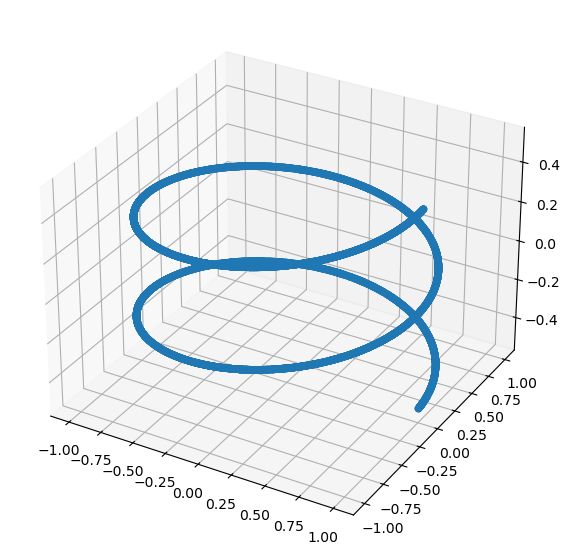

In [3]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')

ax.scatter(*np.transpose(np.array((x_embedding))))
plt.show()

### Autoencoder (3 -> 1) with TF

In [4]:
class Autoencoder(Model):
  def __init__(self):

    super(Autoencoder, self).__init__()
    self.encoder = tf.keras.Sequential(
      [
        layers.Input(shape=(3,)),
        layers.Dense(20, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(1, activation='relu')
      ]
    )

    self.decoder = tf.keras.Sequential(
      [
        layers.Dense(10, activation='relu'),
        layers.Dense(20, activation='relu'),
        layers.Dense(3, activation='relu')   # everybody seems to put a sigmoid activation for the output layer. why?
      ]
    )

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


autoencoder = Autoencoder()


In [6]:
# Optimizer
learning_rate = 0.00001
adam = tf.keras.optimizers.Adam(learning_rate)

# Loss function
def my_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

#autoencoder.compile(optimizer=adam, loss='mse')
autoencoder.compile(optimizer=adam, loss=my_mse)    # It does the same as standard 'mse'

In [7]:
history = autoencoder.fit(x_train, x_train,
          epochs=50,
          batch_size=1,
          validation_data=(x_test, x_test),
          shuffle=True)

Epoch 1/50
   1/8500 [..............................] - ETA: 24:17 - loss: 0.4681

2024-10-09 17:33:24.605982: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


8500/8500 [==============================] - 3s 346us/step - loss: 0.3684 - val_loss: 0.3559
Epoch 2/50
8500/8500 [==============================] - 3s 323us/step - loss: 0.3370 - val_loss: 0.3151
Epoch 3/50
8500/8500 [==============================] - 3s 319us/step - loss: 0.2938 - val_loss: 0.2858
Epoch 4/50
8500/8500 [==============================] - 3s 320us/step - loss: 0.2772 - val_loss: 0.2799
Epoch 5/50
8500/8500 [==============================] - 3s 319us/step - loss: 0.2745 - val_loss: 0.2790
Epoch 6/50
8500/8500 [==============================] - 3s 356us/step - loss: 0.2741 - val_loss: 0.2789
Epoch 7/50
8500/8500 [==============================] - 3s 356us/step - loss: 0.2741 - val_loss: 0.2789
Epoch 8/50
8500/8500 [==============================] - 3s 339us/step - loss: 0.2741 - val_loss: 0.2789
Epoch 9/50
8500/8500 [==============================] - 3s 324us/step - loss: 0.2741 - val_loss: 0.2789
Epoch 10/50
8500/8500 [==============================] - 3s 320us/step - lo

In [8]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1)                 301       
                                                                 
 sequential_1 (Sequential)   (1, 3)                    303       
                                                                 
Total params: 604
Trainable params: 604
Non-trainable params: 0
_________________________________________________________________


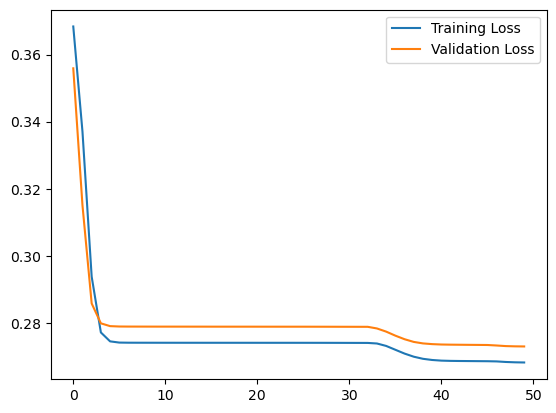

In [9]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

x_train: <class 'pandas.core.frame.DataFrame'>, dims: (8500, 3)
decoded_data: <class 'numpy.ndarray'>, dims: (8500, 3)


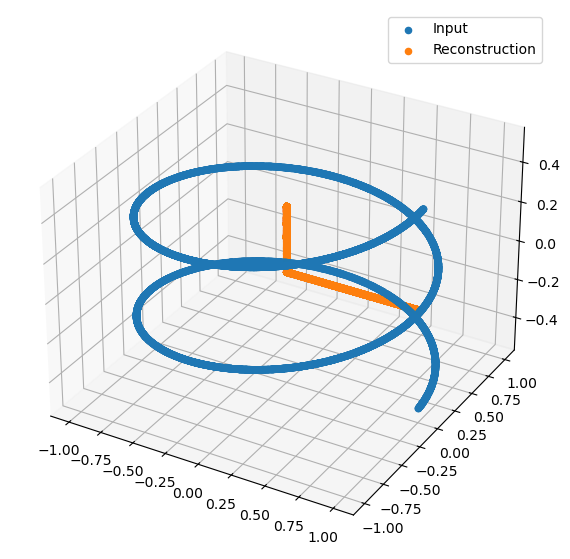

In [10]:
encoded_data = autoencoder.encoder(np.array(x_train)).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

info(x_train)
info(decoded_data)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')

ax.scatter(*np.transpose(np.array((x_train))), 'b')
ax.scatter(*np.transpose(decoded_data), 'r')
ax.legend(labels=["Input", "Reconstruction"])

plt.show()


In [11]:
decoded_data[0:5]

array([[0.        , 0.        , 0.27076203],
       [0.96368647, 0.        , 0.        ],
       [0.99376094, 0.        , 0.        ],
       [0.        , 0.        , 0.18538477],
       [0.        , 0.        , 0.26199394]], dtype=float32)

In [10]:
autoencoder.get_weights()

[array([[-0.35357618, -0.6745669 , -0.298799  ],
        [ 1.3995608 , -0.3280262 , -0.1101864 ],
        [-0.10509256, -0.14638337,  0.4534236 ]], dtype=float32),
 array([ 0.45428988,  0.66509193, -0.5293938 ], dtype=float32),
 array([[ 0.49899668,  0.44300652,  1.0873877 ],
        [ 1.0262978 , -0.3442573 , -0.62101597],
        [ 0.08934268,  0.2304873 ,  0.13236643]], dtype=float32),
 array([-2.1661896e-01,  4.9803460e-01,  5.4959783e-06], dtype=float32),
 array([[-0.99217033,  0.08000182, -0.12278356],
        [ 0.49779454,  0.79845315,  0.09772529],
        [-0.1048141 ,  0.21790907, -4.57379   ]], dtype=float32),
 array([ 0.7217753 , -0.44168833,  0.1980693 ], dtype=float32)]